In [178]:
import numpy as np
from io import StringIO
import time,os,importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [282]:
data_path = "KTN_data/LJ38/4k"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

# Do we try a brute solve?
brute = True

# inverse temperature
beta = 1.0/0.15#20.0#1.0/0.15#12.0

# truncation
Nmax = None



# Load Data

In [283]:

beta, B, K, D, N, u, s, kt, kcon, Emin, index_sel = kio.load_save_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,generate=True,screen=True)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

print("N_states:",N,"N_transitions:",K.data.size)




Aind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.A')):
    Aind = np.append(Aind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Aind = Aind[2:]

Bind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.B')):
    Bind = np.append(Bind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Bind = Bind[2:]

keep = np.zeros(index_sel.size,bool)
keep[Bind] = True

B_states = keep[index_sel]

keep = np.zeros(index_sel.size,bool)
keep[Aind] = True
A_states = keep[index_sel]

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]

print("\n\t%d %s STATES <-> %d %s STATES\n" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta," N_states:",N,"N_rates:",K.data.size,"\n\n")


Generating....
Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900
N_states: 900 N_transitions: 2284

	5 oct STATES <-> 128 ico STATES


	beta: 6.666666666666667  N_states: 900 N_rates: 2284 




# "Spy" rate matrix connectivity


- Threshold on min rate to find graph

- Find connected components of graph

- Spectral analysis of groups $O(N M^3)$, where $M$ is approx. max group size

- Find valid QSD / gap, if any exist

- Perform GT on well gapped groups, should have minimal effect on rate





In [172]:
K.eliminate_zeros() 

S = K.minimum(K.transpose()).copy()
S.data = -np.log(S.data)
thresh = 10.0#np.percentile(S.data,50)

nb = diags((~basins).astype(float))
b  = diags((basins).astype(float))

print(S.data.size)
S = nb.dot(S.dot(nb)) + b.dot(S.dot(b))
S.eliminate_zeros()
print(S.data.size)
S.data[S.data>thresh] = 0.0

S.eliminate_zeros()
print(S.data.size)

n_components, labels = connected_components(S)


bc = np.bincount(labels)

gaps = np.zeros((n_components,3))

mK = diags(D)-K

bbc = 0

for lab in tqdm(range(n_components),mininterval=0.0):
    
    sel = labels==lab
    gaps[lab][2] = float(sel.sum() == sel[basins].sum())
    if sel.sum()==1:
        gaps[lab][0] = 1.0
        gaps[lab][1] = sel.sum()
    else:
        v = spla.eigvals(mK[sel,:][:,sel].todense()).real
        if v.min()<1.0e-30:
            lgps = v[v.argsort()[1:]]/1.0e-30
        else:
            lgps = v[v.argsort()[1:]]/v[v.argsort()[:-1]]
        
        gaps[lab][0] = lgps.max()
        gaps[lab][1] = sel.sum()-lgps.argmax()
        
        
bbc = int(gaps[:,2].sum())
print("# clusters:",n_components,bbc,"\nmax cluster size:",bc.max())#,bc.size,gaps[bc.argmax()])

 33%|███▎      | 136/410 [00:00<00:00, 812.21it/s] 

2284
1568
1052


100%|██████████| 410/410 [00:00<00:00, 863.41it/s] 

# clusters: 410 69 
max cluster size: 234


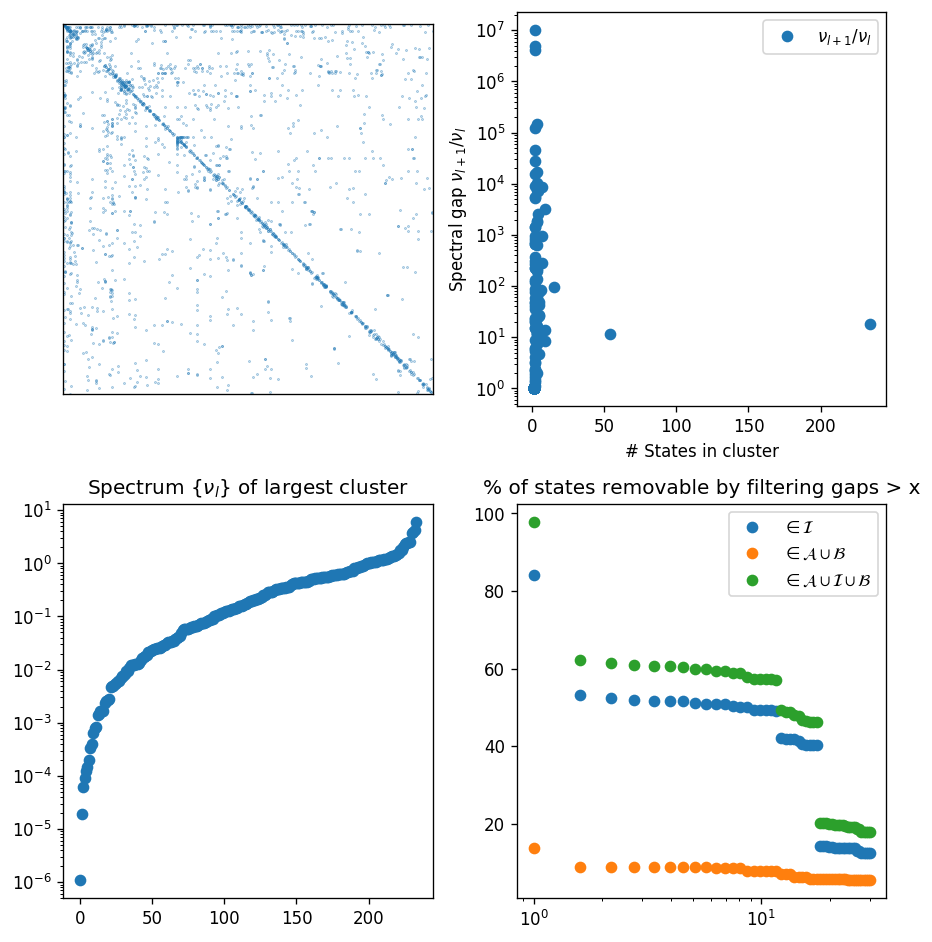

In [173]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=120)

sel = labels==bc.argmax()
v = spla.eigvals(mK[sel,:][:,sel].todense()).real
ax[1,0].semilogy(v[v.argsort()],'o')

selection = gaps[:,0]>=1.0

x = np.exp(np.linspace(np.log(0.001),np.log(gaps.max()),40))
ax[0,1].semilogy(bc[selection],gaps[selection][:,0],'o',label=r"$\nu_{l+1}/\nu_l$")
#ax[0,1].set_xticks(np.arange(20))

ns = np.zeros((50,2))
gg = np.linspace(1.,30.,ns.shape[0])
for ii,ll in enumerate(gg):
    ns[ii][0] = gaps[(gaps[:,0]>=ll)*(gaps[:,2].astype(bool)),1].sum()/float(N) * 100.0
    ns[ii][1] = gaps[(gaps[:,0]>=ll)*(~gaps[:,2].astype(bool)),1].sum()/float(N) * 100.0
    
    


ax[1,1].semilogx(gg,ns[:,1],'o',label=r"$\in\mathcal{I}$")
ax[1,1].semilogx(gg,ns[:,0],'o',label=r"$\in\mathcal{A\cup B}$")
ax[1,1].semilogx(gg,ns[:,0]+ns[:,1],'o',label=r"$\in\mathcal{A\cup I\cup B}$")

ax[0,1].legend()
ax[1,1].legend()

ax[0,0].spy(K,markersize=0.1)

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])


ax[0,1].set_ylabel(r"Spectral gap $\nu_{l+1}/\nu_l$")
ax[0,1].set_xlabel("# States in cluster")

ax[1,0].set_title(r"Spectrum $\{\nu_l\}$ of largest cluster")



ax[1,1].set_title("% of states removable by filtering gaps > x")

plt.tight_layout()


# Graph transformation to remove intermediate states

 98%|█████████▊| 750/767 [00:00<00:00, 3934.07it/s]

GT regularization removing 767 states:


casting to csr_matrix
GT done, 0 rescans due to LinAlgError


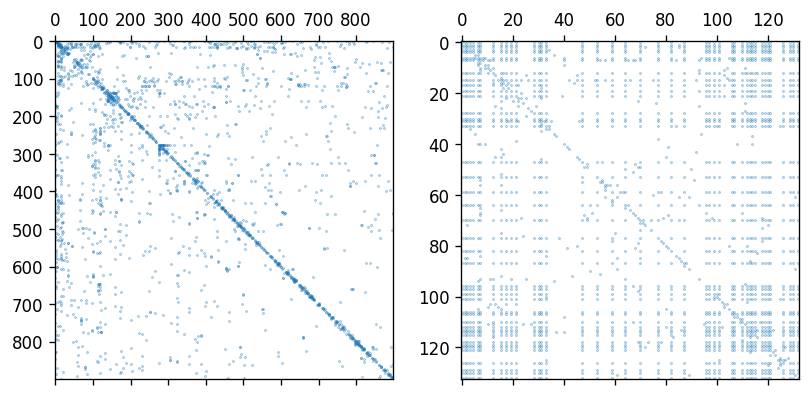

In [174]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=120)


trmb = 150 # block size
ax[0].spy(B,markersize=0.1)


# NB "full_rK" is in fact equal to D-K=(1-B).D in earlier notation - this is done 

rB, rD, full_rK, rN, retry = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=trmb,retK=True,Ndense=50,screen=True)


r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]

rDSS = D[~inter_region]

ax[1].spy(rB,markersize=0.1)


# Testing eigendecomposition of $\mathcal{I}$

3142186.976472007 3142187.85799676
25


"\nplt.semilogy(np.exp(-BF[~B_states])/np.exp(-BF[~B_states]).sum(),'s')\nplt.semilogy(w[:,nsnu.argmin()],'o')\nplt.semilogy(rho,'o')\nplt.semilogy(w[:,tau.argmax()],'.')\n"

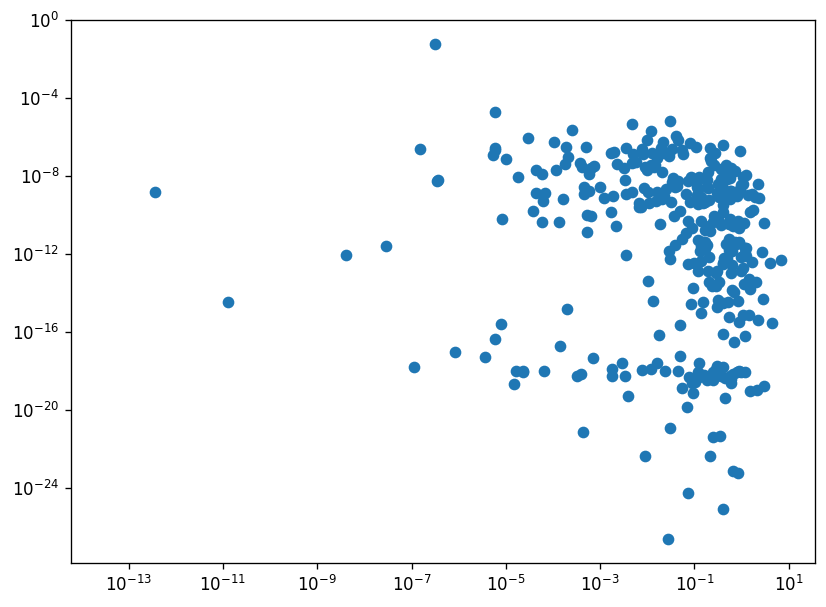

In [300]:
fK = (diags(D)-K).todense()



# A -> B
rho = np.exp(-BF)
rho[~A_states] = 0.0
rho = rho[~B_states] / rho[~B_states].sum()


nu,v,w = spla.eig(fK[~B_states,:][:,~B_states],left=True,right=True)

nuo = nu.real.argsort()
nsnu,v,w = nu[nuo].real, v[:,nuo].real, w[:,nuo].real

tau = np.r_[[w[:,i].sum()*v[:,i].dot(rho)/nsnu[i]/w[:,i].dot(v[:,i]) for i in range(nsnu.size)]]

x = np.linalg.solve(fK[~B_states,:][:,~B_states],rho)

print(tau.sum(),x.sum())

print(tau.argmax())

fig,ax = plt.subplots(1,1,figsize=(8,6),dpi=120)


#print(v.T.dot(rho).argmax())
ax.loglog(nsnu,v.T.dot(rho),'o')
#plt.semilogy(nsnu,'o')
#plt.xlim(0,30)
"""
plt.semilogy(np.exp(-BF[~B_states])/np.exp(-BF[~B_states]).sum(),'s')
plt.semilogy(w[:,nsnu.argmin()],'o')
plt.semilogy(rho,'o')
plt.semilogy(w[:,tau.argmax()],'.')
"""



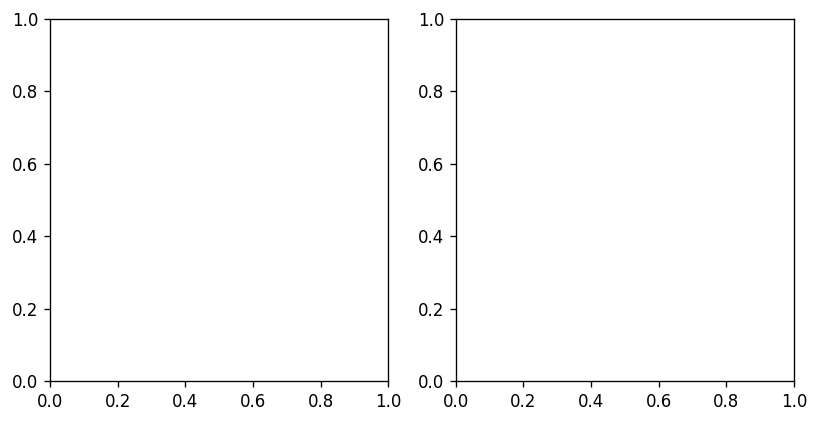

In [268]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=120)

sK = diags(np.exp(+BF/2.0)).dot((diags(D)-K).dot(diags(np.exp(-BF/2.0))))
snu = spla.eigvals(sK[~basins,:][:,~basins].todense()).real


fK = (diags(D)-K).todense()

nu,v,w = spla.eig(fK[~basins,:][:,~basins],left=True,right=True)
nuo = nu.real.argsort()
nsnu,v,w = nu[nuo].real, v[:,nuo].real, w[:,nuo].real


es = (~basins).sum()

dpw = np.sqrt(np.r_[[np.dot(v[:,ie],w[:,ie]) for ie in range(es)]])

for ie in range(es):
    v[:,ie] /= dpw[ie] 
    w[:,ie] /= dpw[ie]


Nb=basins.sum()

S = np.block([[np.eye(Nb),np.zeros((Nb,N-Nb))],[np.zeros((N-Nb,Nb)),v]])
T = np.block([[np.eye(Nb),np.zeros((Nb,N-Nb))],[np.zeros((N-Nb,Nb)),w.T]])
rK = S.dot(np.block([[fK[basins,:][:,basins],fK[basins,:][:,~basins]],[fK[~basins,:][:,basins],fK[~basins,:][:,~basins]]])).dot(T)


rho_B = rho.copy()
rho_B[~B_states] = 0.0

x = np.linalg.solve(fK[~A_states,:][:,~A_states],rho_B[~A_states])


           

    


# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## We also perform same eigendecomposition following additional GT to group all target states

## This is analytically identical, but in practice is numerically beneficial

9.43689570931383e-16
[2.82364241e-12 1.16028118e-05 3.99200430e-05 6.78587074e-04 3.47541589e-01]
9.43689570931383e-16
[1.84179154e-18 1.25178573e-17 2.41721123e-17 2.22551420e-15 1.71537195e-14]


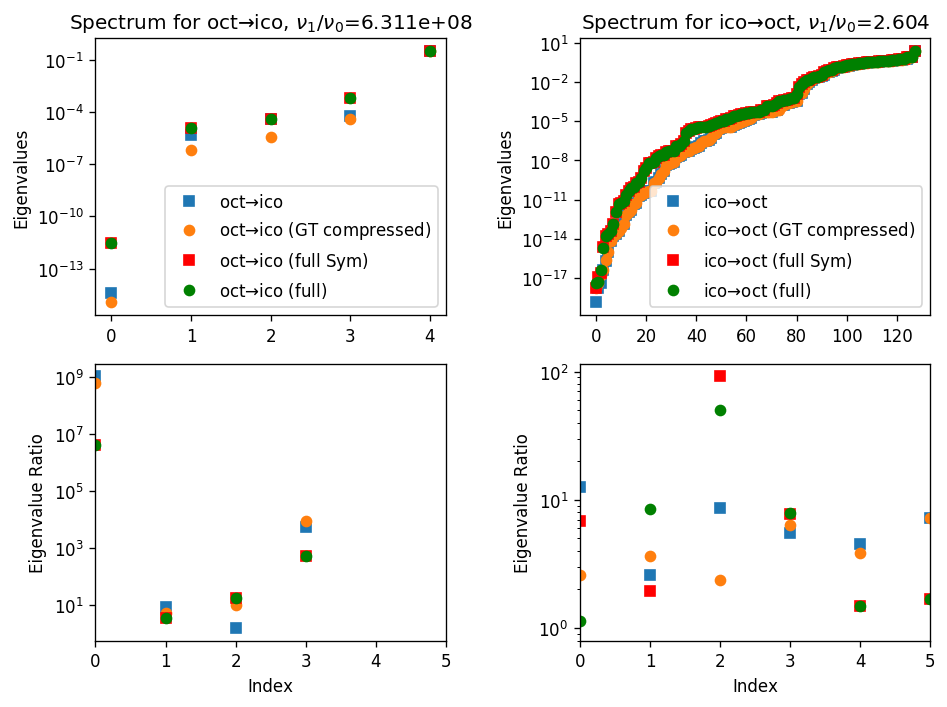

In [24]:
fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=120)#,sharex='col')

kdata = [] # SS,NSS,QSD,nu

fs = [A_states,B_states]

for i, r_s in enumerate([r_A_states,r_B_states]) :
    
    sK = diags(np.exp(+BF/2.0)).dot((diags(D)-K).dot(diags(np.exp(-BF/2.0))))
    
    print(np.abs((sK-sK.transpose()).data).max())
    
    snu = spla.eigvalsh(sK[fs[i],:][:,fs[i]].todense()).real
    snu = snu[snu.argsort()]
    print(snu[:5])
    nsnu = spla.eigvals((diags(D)-K)[fs[i],:][:,fs[i]].todense()).real
    nsnu = nsnu[nsnu.argsort()]
    l, v = spla.eig(full_rK[r_s,:][:,r_s].todense())
    
    
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    
    
    
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    
    
    
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
    
    
    
    
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool)   
    rm_reg[(~r_s).nonzero()[0]] = True
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    
    
    
    rrB, rrD, full_rrK, rrN, retry = gt.gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,retK=True,Ndense=1)
    
    rr_s = r_s[~rm_reg] # starting basin
    
    rl, rv = spla.eig(full_rrK[rr_s,:][:,rr_s].todense())
    
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    C = np.ravel(rrB[~rr_s,:][:,rr_s].sum(axis=0))
    
    gty = spsolve(full_rrK[rr_s,:][:,rr_s].transpose(),np.ones(rr_s.sum()))
    """
    gty = np.zeros(rr_s.sum())
    for ks in tqdm(range(rr_s.sum()),position=0):
        r_rm_reg = rr_s.copy()
        r_rm_reg[rr_s.nonzero()[0][ks]] = False
        gty[ks] = 1.0/np.diagonal(gt.gt_seq(N=rrN,rm_reg=r_rm_reg,B=rrB,D=rrD,trmb=4,retK=True,Ndense=1)[2].todense())[rr_s[~r_rm_reg]][0]
    """
    tau = (gty*rho).sum()
    k_F = (rho/gty).sum()
    
    
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kSS = C.dot(np.diag(rDSS[r_s])).dot(rho)
    
    kNSS = C.dot(np.diag(rrD[rr_s])).dot(rho)
    
    kQSD = C.dot(np.diag(rrD[rr_s])).dot(qsd)
    
    oneKqsd = (full_rrK[rr_s,:][:,rr_s].dot(qsd)).sum()
    
    kdata.append([kSS,kNSS,kQSD,rnu[0],oneKqsd,k_F,1.0/tau,qsd,rho])
    
    
    ax[0,i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[0,i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[0,i].plot(snu,'rs',label=r"%s$\to$%s (full Sym)" % (names[i],names[1-i]))
    ax[0,i].plot(nsnu,'go',label=r"%s$\to$%s (full)" % (names[i],names[1-i]))
    
    ax[1,i].plot(nu[1:]/nu[:-1],'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[1,i].plot(rnu[1:]/rnu[:-1],'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[1,i].plot(snu[1:]/snu[:-1],'rs',label=r"%s$\to$%s (full Sym)" % (names[i],names[1-i]))
    ax[1,i].plot(nsnu[1:]/nsnu[:-1],'go',label=r"%s$\to$%s (full)" % (names[i],names[1-i]))
   
    #ax[0,i].plot(snu[1:]/snu[:-1],'r.',label=r"%s$\to$%s (full Sym)" % (names[i],names[1-i]))
    
       
    
    ax[0,i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],rnu[1]/rnu[0]))
    ax[0,i].set_ylabel("Eigenvalues")
    
    ax[1,i].set_ylabel("Eigenvalue Ratio")
    
    ax[1,i].set_xlabel("Index")
    ax[0,i].set_yscale("log")
    ax[1,i].set_yscale("log")
    ax[1,i].set_xlim(0,5)
    ax[0,i].legend()
    #ax[1,i].legend()
    
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}=k^{QSD}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^{SS}, k^{NSS}, k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"

## Results clearly show QSD for icosahedral basin is strongly non-Boltzmann ($k^{QSD}\neq k^{NSS}$)



	 oct -> ico

	 nu_0 = 1.119e-15

	 1.K.qsd = 1.119e-15. Error to nu_0 = 0.000201%

	 kQSD = 1.119e-15. Error to nu_0 = 0.000201%

	 kF = 1.119e-15. Error to nu_0 = 0.000201%

	 k*= 1.119e-15. Error to nu_0 = 0.000201%

	 kSS = 1.121e-15. Error to nu_0 = 0.1291%

	 kNSS = 8.477e-16. Error to nu_0 = -24.25%

---QSD.max()=0.999999888, rho.max()=0.999999962 ------



	 ico -> oct

	 nu_0 = 1.696e-18

	 1.K.qsd = 2.503e-19. Error to nu_0 = -85.24%

	 kQSD = 2.503e-19. Error to nu_0 = -85.24%

	 kF = 1.081e-14. Error to nu_0 = 6.374e+05%

	 k*= 1.081e-14. Error to nu_0 = 6.37e+05%

	 kSS = 4.033e-14. Error to nu_0 = 2.378e+06%

	 kNSS = 3.669e-15. Error to nu_0 = 2.162e+05%

---QSD.max()=0.9999770081, rho.max()=0.6434249189 ------




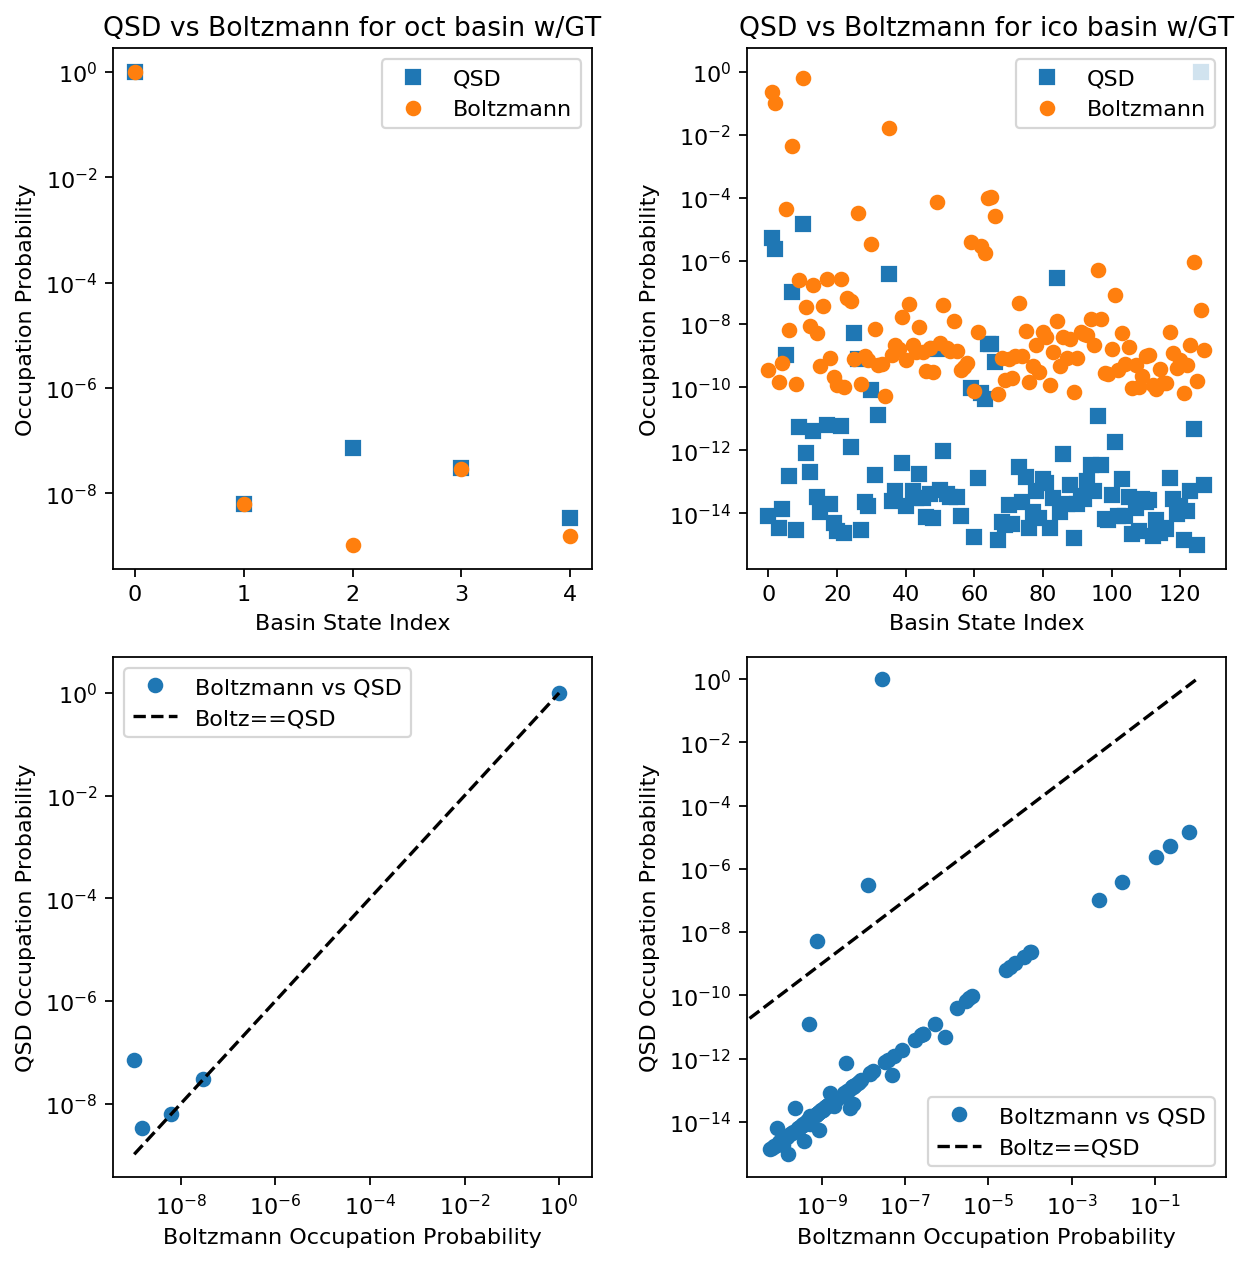

In [10]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    
    #     0: kSS, 1: kNSS, 2: kQSD, 3: nu, 4: 1.K.qsd, 5: k_F, 6: k* =1.0/tau
    
    print("\n\t nu_0 = %4.4g\n\n\t 1.K.qsd = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kQSD = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][2],(kdata[i][2]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kF = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][5],(kdata[i][5]/kdata[i][3])*100.0-100.0))
    
    print("\n\t k*= %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][6],(kdata[i][6]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][0],(kdata[i][0]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kNSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][1],(kdata[i][1]/kdata[i][3])*100.0-100.0))
    
    print("\n---QSD.max()=%4.10g, rho.max()=%4.10g ------\n\n" % (kdata[i][-2].max(),kdata[i][-1].max()))
    
        
    
    ax[0,i].set_title(r"QSD and Boltzmann for %s basin w/GT" % (names[i]))
    ax[0,i].set_ylabel("Occupation Probability")
    ax[0,i].set_xlabel("Basin State Index")
    ax[0,i].plot(kdata[i][-2],'s',label=r"QSD")
    ax[0,i].plot(kdata[i][-1],'o',label=r"Boltzmann")
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    ax[0,i].set_title(r"QSD vs Boltzmann for %s basin w/GT" % (names[i]))
    ax[1,i].set_xlabel("Boltzmann Occupation Probability")
    ax[1,i].set_ylabel("QSD Occupation Probability")
    ax[1,i].plot(kdata[i][-1],kdata[i][-2],'o',label=r"Boltzmann vs QSD")
    
    pc = np.linspace(min(kdata[i][-2].min(),kdata[i][-1].min()),1.0,10,endpoint=True)
    ax[1,i].plot(pc,pc,'k--',label="Boltz==QSD")
    
    ax[1,i].set_yscale("log")
    ax[1,i].set_xscale("log")
    ax[1,i].set_xlim(xmax=5.0)
    ax[1,i].set_ylim(ymax=5.0)
    
    ax[1,i].legend()
    
plt.tight_layout()